In [364]:
import numpy as np
import pandas as pd
import random
import time
from datetime import datetime, timedelta
import seaborn as sns
import pyodbc
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import gc
%matplotlib inline

### Загрузка данных

In [3]:
def sql_orders(str_date, days_from):
    str_date_from = (datetime.strptime(str_date, '%Y-%m-%d') - timedelta(days=days_from)).strftime('%Y-%m-%d')
    sql_orders = '''
    SELECT wbuser_id, COUNT(*) as orders_cnt_{0}, SUM(order_price)/1000 as orders_amount_{0}
    FROM Orders.Orders
    WHERE order_dt > '{1}' AND order_dt <= '{2}' 
    GROUP BY wbuser_id
    '''.format(days_from, str_date_from, str_date)
    return sql_orders 

sql_users = '''
SELECT wbuser_id, id_user_RegHistory_group as reg_history, id_user_old_group as age, id_sex as sex 
, loc, id_user_Purchase_Group as purchase_percent, personal_discount, is_employee
FROM OLAP.dbo.Dim_Users
'''

olap_conn = pyodbc.connect(driver='{SQL Server}', host='10.255.248.88', database='OLAP', trusted_connection='no', uid='spark', pwd='wi1dBe99i@s')
vert_conn = pyodbc.connect('DRIVER=Vertica;SERVER=celeborn.dc.wildberries.ru;PORT=5433;DATABASE=stat;uid=search_user;pwd=f5nbur3z;')


In [4]:
%%time
DATE_0 = '2017-11-10'
df_orders_30 = pd.read_sql(sql_orders(DATE_0, 30), vert_conn)
df_orders_90 = pd.read_sql(sql_orders(DATE_0, 90), vert_conn)
df_orders_180 = pd.read_sql(sql_orders(DATE_0, 180), vert_conn)
df_orders_360 = pd.read_sql(sql_orders(DATE_0, 360), vert_conn)
df_users = pd.read_sql(sql_users, olap_conn)

CPU times: user 2min 32s, sys: 6.4 s, total: 2min 39s
Wall time: 2min 55s


In [5]:
%%time
df_users = pd.merge(df_users, df_orders_30, how='left', on='wbuser_id')
df_users = pd.merge(df_users, df_orders_90, how='left', on='wbuser_id')
df_users = pd.merge(df_users, df_orders_180, how='left', on='wbuser_id')
df_users = pd.merge(df_users, df_orders_360, how='left', on='wbuser_id')

CPU times: user 32.4 s, sys: 3.66 s, total: 36.1 s
Wall time: 36.1 s


In [6]:
del df_orders_30, df_orders_90, df_orders_180, df_orders_360

In [7]:
gc.collect()

84

###  Чистка и предобработка данных

In [8]:
# исключаем юзеров не покупавших более года
df_users = df_users[df_users['orders_cnt_360'].notnull()]

In [9]:
# исключаем сотрудников компании
df_users = df_users[df_users['is_employee'] != True]
df_users.drop('is_employee', axis=1, inplace=True)

In [10]:
# избавляемся от nan
df_users.fillna(value=0, inplace=True)

In [11]:
# кодируем локации
df_users['loc'].replace(to_replace= ['RU','BY','KZ','KG'], value=[0,1,2,2], inplace=True)

In [303]:
# итоговый вид
df_users.head().transpose()

,0,1,2,3,4
wbuser_id,1228.000,1247.000,1257.000,1261.000,1269.000
reg_history,6.000,6.000,6.000,6.000,6.000
age,5.000,6.000,0.000,0.000,7.000
sex,1.000,1.000,0.000,1.000,1.000
loc,0.000,0.000,0.000,0.000,0.000
purchase_percent,5.000,4.000,1.000,2.000,5.000
personal_discount,17.000,17.000,0.000,15.000,17.000
orders_cnt_30,0.000,20.000,2.000,4.000,3.000
orders_amount_30,0.000,40.097,3.969,17.962,1.338
orders_cnt_90,10.000,120.000,2.000,31.000,8.000


### Проверка фичей на предиктивность

In [14]:
# проверим способность выбранных фич предстказывать факт покупки в следующем месяце
df_orders_test = pd.read_sql(sql_orders('2017-12-10', 30), vert_conn)
df_orders_test['order_trg'] = 1

In [15]:
df_users = pd.merge(df_users, df_orders_test[['wbuser_id','order_trg']], how='left', on='wbuser_id')
df_users.fillna(value=0, inplace=True)

In [16]:
del df_orders_test

In [17]:
sum(df_users['order_trg'])/len(df_users['order_trg'])

0.34668768792053278

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_users.iloc[:,1:-1], df_users.iloc[:,-1], test_size=0.1, random_state=42)

In [19]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [22]:
%%time
xgb_params = {
                'eta': 0.1,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'silent': 1,
                'nthread': 4
            }
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=300, evals=[(dtest, 'eval')],
                      early_stopping_rounds=20, verbose_eval=100)
y_pred = xgb_model.predict(dtest)

[0]	eval-auc:0.867534
Will train until eval-auc hasn't improved in 20 rounds.
[100]	eval-auc:0.886859
[200]	eval-auc:0.889449
CPU times: user 26min 8s, sys: 1.03 s, total: 26min 9s
Wall time: 8min 48s


In [23]:
# итогове качество предсказания 
print('roc_auc_score:', roc_auc_score(y_test, y_pred))

roc_auc_score: 0.890351031797


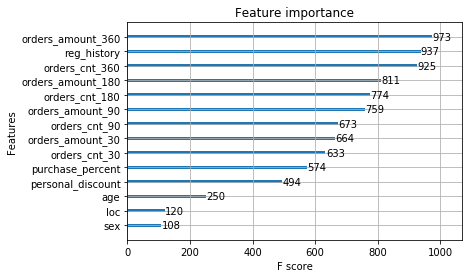

In [24]:
# важность фич для предсказания
xgb.plot_importance(xgb_model)

In [30]:
del X_train, X_test, y_train, y_test, dtrain, dtest

In [357]:
del df_users['order_trg']

In [358]:
df_users.head().transpose()

,0,1,2,3,4
wbuser_id,1228.000,1247.000,1257.000,1261.000,1269.000
reg_history,6.000,6.000,6.000,6.000,6.000
age,5.000,6.000,0.000,0.000,7.000
sex,1.000,1.000,0.000,1.000,1.000
loc,0.000,0.000,0.000,0.000,0.000
purchase_percent,5.000,4.000,1.000,2.000,5.000
personal_discount,17.000,17.000,0.000,15.000,17.000
orders_cnt_30,0.000,20.000,2.000,4.000,3.000
orders_amount_30,0.000,40.097,3.969,17.962,1.338
orders_cnt_90,10.000,120.000,2.000,31.000,8.000


### Кодирование фичей

In [368]:
def strat_feature(feat, strats = 10):
    p = [np.percentile(feat, 100*i/strats) for i in range(strats+1)]
    p[0] = 0
    p[-1] += 1
    strat_feat = 0*feat
    for i in range(strats):
        strat_feat += i*((feat >= p[i])&(feat < p[i+1]))
    return strat_feat.astype(int)

In [369]:
df_users_ = df_users.iloc[:,:6]
for feat in df_users.columns[6:]:
    df_users_[feat] = strat_feature(df_users[feat])

In [41]:
# del df_users_['order_trg']

In [370]:
df_users_.head().transpose()

,0,1,2,3,4
wbuser_id,1228,1247,1257,1261,1269
reg_history,6,6,6,6,6
age,5,6,0,0,7
sex,1,1,0,1,1
loc,0,0,0,0,0
purchase_percent,5,4,1,2,5
personal_discount,9,9,6,9,9
orders_cnt_30,6,9,7,7,7
orders_amount_30,6,9,7,8,6
orders_cnt_90,7,9,5,9,7


### Кластеризация 

In [371]:
# генерим подвыборку для визуализации 
random.seed(42)
ind_sample = random.sample(range(df_users_.shape[0]), 100000)
df_users_sample = df_users_.iloc[ind_sample,1:]

In [372]:
%%time
# создадаем TSNE-визуализацию подвыборки 
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=4)
data_2d_tsne = tsne.fit_transform(df_users_sample)

CPU times: user 31min 46s, sys: 23.4 s, total: 32min 9s
Wall time: 16min 10s


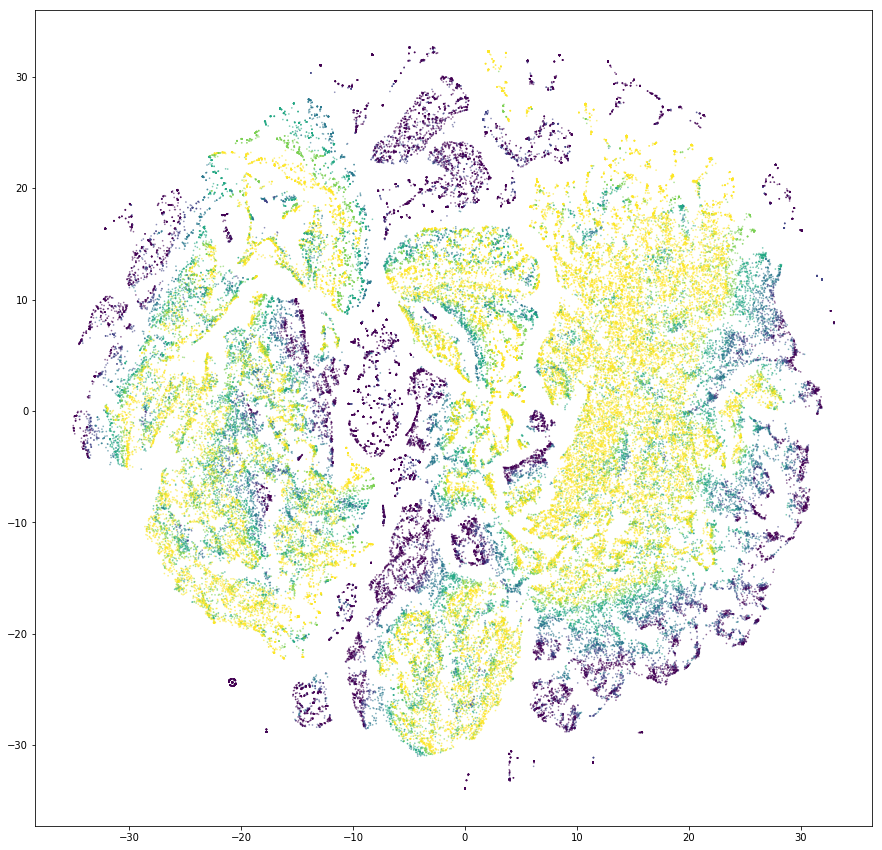

In [374]:
plt.figure(figsize=(15,15))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], s=0.5, alpha=0.5, c=df_users_sample['reg_history'])

In [376]:
# кластеризация методом KMeans
CLUST_NUM = 50
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CLUST_NUM, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, precompute_distances='auto', 
                verbose=0, random_state=42, copy_x=True, n_jobs=4, algorithm='auto')

In [377]:
%%time
kmeans.fit(df_users_.iloc[:,1:])

CPU times: user 9.85 s, sys: 1.64 s, total: 11.5 s
Wall time: 22min 9s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=50, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [378]:
df_users_['clust_id'] = kmeans.labels_

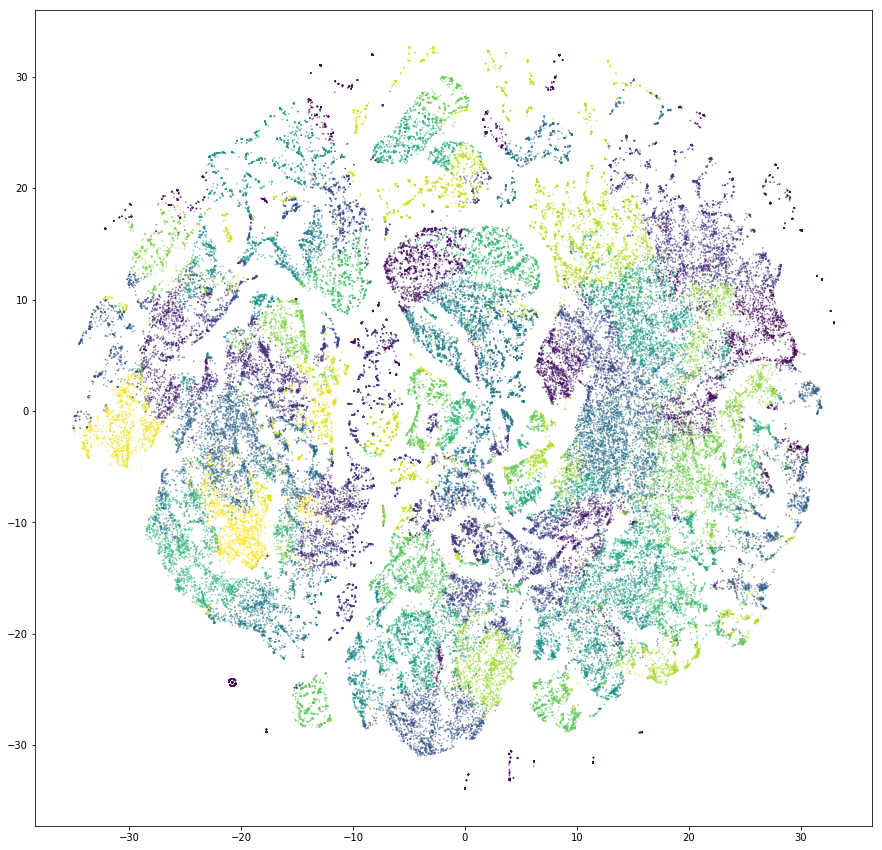

In [380]:
# посмотрим на полученные кластеры, для этого снова используем TSNE 
plt.figure(figsize=(15,15))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], s=0.5, alpha=0.5, c=df_users_.iloc[ind_sample, -1])

### Кластерная выборка vs. Обычная выборка - анализ качества

In [381]:
# задаем необходимый размер выборки 
SAMP_SIZE = 0.01
int(SAMP_SIZE*df_users_.shape[0])

29018

In [382]:
# кластерный сэмплер 
def cluster_sampler(rand_seed=42):
    random.seed(rand_seed)
    clust_users = []
    for i in range(CLUST_NUM):
        df_users_clust = df_users_[df_users_['clust_id'] == i]
        clust_users += random.sample(list(df_users_clust['wbuser_id']), int(df_users_clust.shape[0]*SAMP_SIZE))
    df_users_clust = df_users[df_users['wbuser_id'].isin(clust_users)]
    return df_users_clust

In [383]:
# baseline сэмплер - обычная случайная выборка
def baseline_sampler(rand_seed=42):
    random.seed(rand_seed)
    baseln_users = random.sample(list(df_users_['wbuser_id']), int(df_users_.shape[0]*SAMP_SIZE))
    df_users_baseln = df_users[df_users['wbuser_id'].isin(baseln_users)] 
    return df_users_baseln

In [385]:
%%time
# генерим выборки 
df_users_clust = cluster_sampler()
df_users_baseln = baseline_sampler()

CPU times: user 2.11 s, sys: 48 ms, total: 2.16 s
Wall time: 2.16 s


CPU times: user 30.3 s, sys: 88 ms, total: 30.4 s
Wall time: 30.4 s


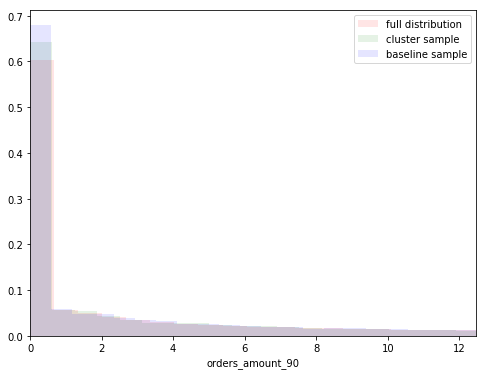

In [391]:
%%time
# посмотрим как выглядят полное распределение и распределения в выборках для некоторой фичи 
feat = 'orders_amount_90'
del fig, ax
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_users[feat], bins=10000, kde=False, rug=False, norm_hist=True, hist_kws={'alpha': 0.1, 'color': 'r'}, label='full distribution')
sns.distplot(df_users_clust[feat], bins=2000, kde=False, rug=False, norm_hist=True, hist_kws={'alpha': 0.1, 'color': 'g'}, label='cluster sample')
sns.distplot(df_users_baseln[feat], bins=2000, kde=False, rug=False, norm_hist=True, hist_kws={'alpha': 0.1, 'color': 'b'}, label='baseline sample')
plt.legend()

ax.set_xlim([0, np.percentile(df_users[feat], 70)])
# ax.set_ylim([0, 0.5])

In [417]:
# задаем метрику качества выборки для дискретных фич  
def quality_discr(feat0, feat1):
    feat0_dict = dict(zip(feat0.value_counts().index, feat0.value_counts().values) )   
    feat1_dict = dict(zip(feat1.value_counts().index, feat1.value_counts().values) )
    met = sum([ abs(feat0_dict[k]/sum(feat0_dict.values())-feat1_dict[k]/sum(feat1_dict.values())) for k in feat0_dict.keys()]) 
    return met

In [507]:
# задаем метрику качества выборки для непрерывных фич
def quality_cont(feat0, feat1, n_parts = 100):
    p = [np.percentile(feat0, 100*i/n_parts) for i in range(n_parts+1)]
    feat_ = list(feat1.sort_values())
    count = 0
    p_ind = 1
    met = 0 
    for i in range(len(feat_)):
        if feat_[i] <= p[p_ind]:
            count += 1
        else:
            met += abs(1/n_parts - count/len(feat_))
            count = 0
            p_ind += 1
    met += abs(1/n_parts - count/len(feat_))
    return met

In [486]:
# задаем метрику качества сэмплеров - среднее качество для нескольких сгенерированных выборок 
def sampler_quality(sampler_func, quality_func, feat, n_samples=30):
    qual_sample = []
    for i in range(n_samples):
        df_users_ = sampler_func(rand_seed=i)
        qual_sample.append(quality_func(df_users[feat], df_users_[feat]))
    return np.mean(qual_sample)

In [407]:
# вывод качества сэмплеров
def sampler_quality_print(feats, quality_func):
    samplers = [('кластерный сэмплер', cluster_sampler),  ('baseline сэмплер', baseline_sampler)]
    for feat in feats:
        print('\nкачество сэмплера для фичи:', feat) 
        for sampler in samplers:
            print(sampler[0], '%.4f' % sampler_quality(sampler[1], quality_func, feat) )

In [494]:
%%time
# выводим результаты замера качества сэмплеров для дискретных фич (чем меньше значение, тем лучше)
discr_feats = ['reg_history', 'age', 'sex', 'loc', 'purchase_percent']
sampler_quality_print(discr_feats, quality_discr)


качество сэмплера для фичи: reg_history
кластерный сэмплер 0.0080
baseline сэмплер 0.0090

качество сэмплера для фичи: age
кластерный сэмплер 0.0078
baseline сэмплер 0.0112

качество сэмплера для фичи: sex
кластерный сэмплер 0.0060
baseline сэмплер 0.0070

качество сэмплера для фичи: loc
кластерный сэмплер 0.0038
baseline сэмплер 0.0039

качество сэмплера для фичи: purchase_percent
кластерный сэмплер 0.0069
baseline сэмплер 0.0089
CPU times: user 4min 59s, sys: 1.81 s, total: 5min 1s
Wall time: 5min 1s


In [509]:
%%time
# выводим результаты замера качества сэмплеров для непрерывных фич (чем меньше значение, тем лучше)
cont_feats = ['personal_discount', 'orders_cnt_30', 'orders_amount_30', 'orders_cnt_90', 'orders_amount_90',\
'orders_cnt_180', 'orders_amount_180', 'orders_cnt_360', 'orders_amount_360']
sampler_quality_print(cont_feats, quality_cont)


качество сэмплера для фичи: personal_discount
кластерный сэмплер 1.8608
baseline сэмплер 1.8606

качество сэмплера для фичи: orders_cnt_30
кластерный сэмплер 1.5782
baseline сэмплер 1.5780

качество сэмплера для фичи: orders_amount_30
кластерный сэмплер 1.2456
baseline сэмплер 1.2456

качество сэмплера для фичи: orders_cnt_90
кластерный сэмплер 1.3262
baseline сэмплер 1.3266

качество сэмплера для фичи: orders_amount_90
кластерный сэмплер 0.7615
baseline сэмплер 0.7631

качество сэмплера для фичи: orders_cnt_180
кластерный сэмплер 1.1326
baseline сэмплер 1.1330

качество сэмплера для фичи: orders_amount_180
кластерный сэмплер 0.3817
baseline сэмплер 0.3825

качество сэмплера для фичи: orders_cnt_360
кластерный сэмплер 1.0114
baseline сэмплер 1.0123

качество сэмплера для фичи: orders_amount_360
кластерный сэмплер 0.0473
baseline сэмплер 0.0471
CPU times: user 36min 30s, sys: 3.2 s, total: 36min 33s
Wall time: 36min 34s


### Подведем итоги
* Используем базу юзеров с 14 фичами - общие данные (reg_history, age, sex, loc) и покупательские фичи (purchase_percent, personal_discount, orders_cnt_30, orders_amount30, ... orders_cnt_360, orders_amount_360)
* Выбранные фичи достаточно неплохо описывают покупательную активность, в т.ч. предсказывают факт покупки с качеством ~ 0.9 AUC
* TSNE-визуализация показывает, что данные кластериризуются на несколько десятков кластеров, бьем на кластеры с помощью KMeans
* Задаем и считаем метрики качества сэмплинга для каждой фичи, отдельно для дискретных и непрерывных фич 
* В итоге для кластерного сэмплера получаем слегка лучшее качество, чем у простого рандома, для большинства значимых фич

In [511]:
# выгрузка кластерного сэмпла в файл
df_users_clust.to_csv('users_sample.csv')